In [414]:
import sys
import os
from copy import deepcopy
sys.path.append("..")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from webapp.utils.azure_utils import KeyVault, DataLake
import dask.dataframe as dd
import dask.array as da
import river
from data_prep.prep import MeterDataSet
import datetime as dt
import random

In [2]:
# Connect to Storage Account
vault = KeyVault(keyVaultName = "keyvaultdva2022")
storage_credential = vault.get_secret(secretName = "storagePrimaryKey")
storage = DataLake(account_name = "storageaccountdva", credential = storage_credential)

In [422]:
file_system = "energyhub"
norm_dir = "/data_parq/norm"
meters_dir = "/data_parq/meters"
meta_dir = "/data_parq/metadata"
weather_dir = "/data_parq/weather"
bad_building_dir = "/bad_buildings"
dest_dir = "/PartitionedParqs/norm_output"

## Read in 1 building

In [292]:
file1 = "norm_Panther_assembly_Carrol.parq"

In [293]:
df1 = storage.pandas_read(file_system, norm_dir, file1)

In [294]:
len(df1)

14156

In [295]:
df1.columns

Index(['timestamp', 'building_id', 'electricity', 'site_id', 'sq_meter',
       'primary_space_usage', 'air_temperature', 'dew_temperature',
       'wind_direction', 'wind_speed', 'usage_lag1', 'usage_lag2',
       'usage_lag3', 'hour', 'weekday', 'month', 'year', 'weekday_hour', 'ts',
       'hour_x', 'hour_y', 'month_x', 'month_y', 'weekday_x', 'weekday_y'],
      dtype='object')

In [296]:
df1 = df1.drop(columns=['usage_lag1', 'usage_lag2',
       'usage_lag3'])

In [18]:
def usage_lag (df, lag_col):
    df['usage_lag1'] = df[lag_col].shift(1)
    df['usage_lag2'] = df[lag_col].shift(2)
    df['usage_lag3'] = df[lag_col].shift(3)
    return df

In [297]:
df1 = usage_lag(df1, 'electricity')

In [298]:
df1[['timestamp', 'electricity','usage_lag1', 'usage_lag2','usage_lag3' ]].head()

,timestamp,electricity,usage_lag1,usage_lag2,usage_lag3
0,2016-05-01 19:00:00,59.7865,NaN,NaN,NaN
1,2016-05-20 18:00:00,9.0017,59.7865,NaN,NaN
2,2016-05-20 19:00:00,10.1020,9.0017,59.7865,NaN
3,2016-05-20 20:00:00,11.3022,10.1020,9.0017,59.7865
4,2016-05-20 21:00:00,14.1027,11.3022,10.1020,9.0017


<AxesSubplot:>

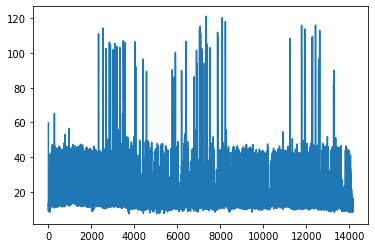

In [299]:
df1['electricity'].plot()

## River Stream test for 1 building

In [165]:
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import stream
from river import ensemble

In [200]:
df1.to_csv("df1.csv")

In [300]:
X = df1.drop(columns = ['building_id', 'site_id', 'primary_space_usage']).dropna()
y = X.pop("electricity")

In [301]:

for xi, yi in stream.iter_pandas(X, y):
    print(xi, yi)
    break

{'timestamp': Timestamp('2016-05-20 20:00:00'), 'sq_meter': 595.7, 'air_temperature': 25.6, 'dew_temperature': 20.6, 'wind_direction': 0.0, 'wind_speed': 0.0, 'hour': 20, 'weekday': 4, 'month': 5, 'year': 2016, 'weekday_hour': '4-20', 'ts': 3380.0, 'hour_x': 0.4999999999999958, 'hour_y': -0.866025403784441, 'month_x': -0.6721967996602096, 'month_y': -0.7403725160529475, 'weekday_x': 0.7330518718298338, 'weekday_y': 0.6801727377709115, 'usage_lag1': 10.102, 'usage_lag2': 9.0017, 'usage_lag3': 59.7865} 11.3022


In [409]:
X_y = stream.iter_pandas(X, y)

model = compose.Select('air_temperature', 'dew_temperature',
       'wind_direction', 'wind_speed', 
       'month', 'weekday', 'hour',  
       'hour_x', 'hour_y','month_x','month_y','weekday_x','weekday_y',
       'usage_lag1', 'usage_lag2', 'usage_lag3')
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optim.SGD(lr=0.003))


metric = metrics.R2()

evaluate.progressive_val_score(X_y, model, metric, moment='timestamp',
              delay=dt.timedelta(minutes=60)).get()







0.784120639791893

Text(0.5, 1.0, 'R2: 0.784121')

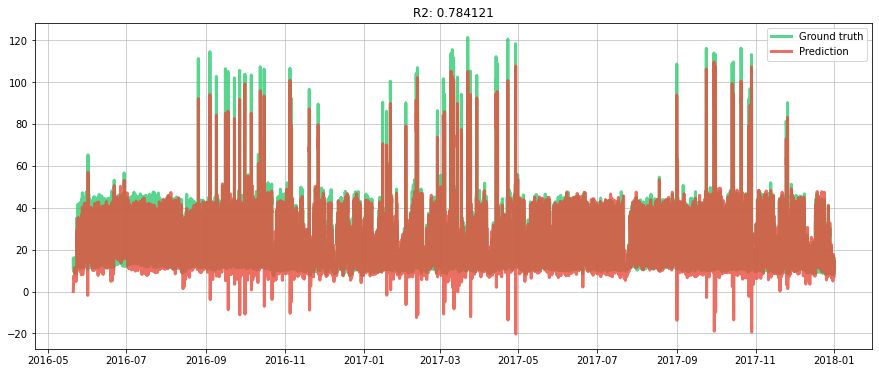

In [312]:
# Plot the results
fig, ax = plt.subplots(figsize=(15, 6))
ax.grid(alpha=0.75)
ax.plot(time, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(time, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

## Package it up to use for each building

In [102]:
paths = storage.list_directory_contents(file_system, norm_dir)
file_names = []
for file in paths[:-1]:
    file_names.append(file.split("/")[2])


In [410]:
def mini_model(building_file, lr):
    #get building name
    building = building_file.replace("norm_", "").replace(".parq", "")

    #model
    building_df = storage.pandas_read(file_system, norm_dir, building_file)
    building_df = building_df.drop(columns=['usage_lag1', 'usage_lag2',
        'usage_lag3'])
    building_df = usage_lag(building_df, 'electricity')
    X = building_df.drop(columns = ['building_id', 'site_id', 'primary_space_usage']).dropna()
    y = X.pop("electricity")
    X_y = stream.iter_pandas(X, y)

    model = compose.Select('air_temperature', 'dew_temperature',
            'wind_direction', 'wind_speed', 
            'month', 'weekday', 'hour',  
            'hour_x', 'hour_y','month_x','month_y','weekday_x','weekday_y',
            'usage_lag1', 'usage_lag2', 'usage_lag3')
    model |= preprocessing.StandardScaler()
    model |= linear_model.LinearRegression(optimizer=optim.SGD(lr))

    metric = metrics.R2()
    R2 = evaluate.progressive_val_score(X_y, model, metric, moment='timestamp',
              delay=dt.timedelta(minutes=60)).get()
    return round(R2, 2)

In [411]:
def build_model(building_file):
    """
    Input: parq building file
    Return: Result df with building name, timestamp, y_true, y_pred, y_norm and R2
    """
    #get building name
    building = building_file.replace("norm_", "").replace(".parq", "")

    #model
    building_df = storage.pandas_read(file_system, norm_dir, building_file)
    building_df = building_df.drop(columns=['usage_lag1', 'usage_lag2',
        'usage_lag3'])
    building_df = usage_lag(building_df, 'electricity')
    X = building_df.drop(columns = ['building_id', 'site_id', 'primary_space_usage']).dropna()
    y = X.pop("electricity")
    X_y = stream.iter_pandas(X, y)

    model = compose.Select('air_temperature', 'dew_temperature',
            'wind_direction', 'wind_speed', 
            'month', 'weekday', 'hour',  
            'hour_x', 'hour_y','month_x','month_y','weekday_x','weekday_y',
            'usage_lag1', 'usage_lag2', 'usage_lag3')
    model |= preprocessing.StandardScaler()
    model |= linear_model.LinearRegression(optimizer=optim.SGD(lr=0.003))

    metric = metrics.R2()

    #Get weights, intercepts, y_trues and y_preds
    time = []

    y_trues = []
    y_preds = []
    weights = []
    intercepts = []


    for xi, yi in X_y:

        # Obtain the prior prediction and update the model
    
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the error metric
        metric.update(yi, y_pred)

        # Store the true value and the prediction
        time.append(xi['timestamp'])

        y_trues.append(yi)
        y_preds.append(y_pred)
        weights.append(model['LinearRegression'].weights)
        intercepts.append(model['LinearRegression'].intercept)

    #Get X_scaled values
    X_raw = pd.DataFrame(X)
    X_raw = X_raw[['air_temperature', 'dew_temperature',
            'wind_direction', 'wind_speed', 
            'month', 'weekday', 'hour',  
            'hour_x', 'hour_y','month_x','month_y','weekday_x','weekday_y',
            'usage_lag1', 'usage_lag2', 'usage_lag3']]
    X_raw['air_temperature'] = 25
    X_raw['dew_temperature'] = 25
    X_raw['wind_direction'] = 0
    X_raw['wind_speed'] = 0
    stream_df = stream.iter_pandas(X_raw)
    scaler = preprocessing.StandardScaler()
    X_scaled = []

    for x in stream_df:
        scaled = scaler.learn_one(x[0]).transform_one(x[0])
        X_scaled.append(scaled)

    #obtain y_norm
    y_norms = [0] *len(y_trues)
    
    for i in range(1, len(y_trues)):
        y_norms[i] = sum(weights[i-1][k]*X_scaled[i][k] for k in X_scaled[i])+ intercepts[i-1]
    
    return building, time, y_trues, y_preds, y_norms, round(metric.get(), 2)




In [371]:
def plot(time, y_trues, y_norms, metric, building_name):
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.grid(alpha=0.75)
    ax.plot(time, y_trues, lw=3, color='#009900', alpha=0.8, label='Ground truth')
    # ax.plot(time, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax.plot(time, y_norms, lw=3, color='#D6DBD4', alpha=0.9, label='Normalized Values')
    ax.legend()
    ax.set_title(f'Actual vs Normalized values for {building_name} (R2 = {metric})')

In [391]:
def create_output(building, time, y_trues, y_preds, y_norms, metric):
    df = pd.DataFrame(list(zip(time, y_trues, y_preds, y_norms)),
                         columns=['timestamp', 
                                    'y_trues', 'y_preds', 'y_norms'])
    df['building'] = building
    df['R2'] = metric
    return df

In [429]:
for file in file_names:
    building, time, y_trues, y_preds, y_norms, metric = build_model(file)
    output_df = create_output(building, time, y_trues, y_preds, y_norms, metric)
    file_name = "norm_output_" + str(building) + ".parq"
    output_df.to_parquet(path = file_name, engine = "pyarrow", compression = "gzip", index = False)
    storage.upload(file_system, directory = dest_dir, file_name = file_name, file_path = file_name, overwrite=True)
    os.remove(file_name)

norm_output_Bear_assembly_Angel.parq write complete
norm_output_Bear_assembly_Beatrice.parq write complete
norm_output_Bear_assembly_Diana.parq write complete
norm_output_Bear_assembly_Genia.parq write complete
norm_output_Bear_assembly_Jose.parq write complete
norm_output_Bear_assembly_Roxy.parq write complete
norm_output_Bear_assembly_Ruby.parq write complete
norm_output_Bear_education_Alfredo.parq write complete
norm_output_Bear_education_Alvaro.parq write complete
norm_output_Bear_education_Arnold.parq write complete
norm_output_Bear_education_Augusta.parq write complete
norm_output_Bear_education_Austin.parq write complete
norm_output_Bear_education_Babara.parq write complete
norm_output_Bear_education_Benita.parq write complete
norm_output_Bear_education_Bob.parq write complete
norm_output_Bear_education_Bonita.parq write complete
norm_output_Bear_education_Bulah.parq write complete
norm_output_Bear_education_Chad.parq write complete
norm_output_Bear_education_Chana.parq write co

In [421]:
# # Tuning Experiments

# learning_rates = [0.001, 0.002, 0.003, 0.004, 0.005]
# for i in range(10):
#    result_dict = {}
  
#    R2_scores = []
#    for file in random.sample(file_names, 10):
#       for rate in learning_rates:
#          R2 = mini_model(file, rate)
#       #save the result
#          R2_scores.append(R2)
#       result_dict[str(rate)] = np.mean(R2_scores)
#    print(f'run {i}: best rate is {sorted(result_dict.items(), key=lambda x: x[1], reverse=True)[0]}')
   
   

run 0: best rate is ('0.001', -12893.541000000001)
run 0: best rate is ('0.002', 0.7929999999999999)
run 0: best rate is ('0.002', 0.7929999999999999)
run 0: best rate is ('0.004', 0.8229999999999998)
run 0: best rate is ('0.005', 0.842)
run 1: best rate is ('0.001', 0.921)
run 1: best rate is ('0.001', 0.921)
run 1: best rate is ('0.001', 0.921)


KeyboardInterrupt: 